

# Working with sensor locations

This tutorial describes how to read and plot sensor locations, and how
MNE-Python handles physical locations of sensors.
As usual we'll start by importing the modules we need:


In [1]:
# Authors: The MNE-Python contributors.
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import mne

## About montages and layouts

`Montages <mne.channels.DigMontage>` contain sensor positions in 3D (x, y, z
in meters), which can be assigned to existing EEG/MEG data. By specifying the
locations of sensors relative to the brain,
`Montages <mne.channels.DigMontage>` play an important role in computing the
forward solution and inverse estimates.

In contrast, `Layouts <mne.channels.Layout>` are *idealized* 2D
representations of sensor positions. They are primarily used for arranging
individual sensor subplots in a topoplot or for showing the *approximate*
relative arrangement of sensors as seen from above.

<div class="alert alert-info"><h4>Note</h4><p>If you're working with EEG data exclusively, you'll want to use
   `Montages <mne.channels.DigMontage>`, not layouts. Idealized montages
   (e.g., those provided by the manufacturer, or the ones shipping with
   MNE-Python mentioned below) are typically referred to as
   :term:`template montages <template montage>`.</p></div>

## Working with built-in montages
.. admonition:: Computing sensor locations
    :class: sidebar note

    If you are interested in how standard (idealized) EEG sensor positions
    are computed on a spherical head model, make sure to check out the
    `eeg_positions`_ repository.

The 3D coordinates of MEG sensors are included in the raw recordings from MEG
systems. They are automatically stored in the ``info`` attribute of the
`~mne.io.Raw` object upon loading. EEG electrode locations are much more
variable because of differences in head shape. Idealized montages
(":term:`template montages <template montage>`") for many EEG systems are
included in MNE-Python, and you can get an overview of them by using
:func:`mne.channels.get_builtin_montages`:



In [3]:
builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
for montage_name, montage_description in builtin_montages:
    print(f"{montage_name}: {montage_description}")

standard_1005: Electrodes are named and positioned according to the international 10-05 system (343+3 locations)
standard_1020: Electrodes are named and positioned according to the international 10-20 system (94+3 locations)
standard_alphabetic: Electrodes are named with LETTER-NUMBER combinations (A1, B2, F4, …) (65+3 locations)
standard_postfixed: Electrodes are named according to the international 10-20 system using postfixes for intermediate positions (100+3 locations)
standard_prefixed: Electrodes are named according to the international 10-20 system using prefixes for intermediate positions (74+3 locations)
standard_primed: Electrodes are named according to the international 10-20 system using prime marks (' and '') for intermediate positions (100+3 locations)
biosemi16: BioSemi cap with 16 electrodes (16+3 locations)
biosemi32: BioSemi cap with 32 electrodes (32+3 locations)
biosemi64: BioSemi cap with 64 electrodes (64+3 locations)
biosemi128: BioSemi cap with 128 electrodes (1

These built-in EEG montages can be loaded with
`mne.channels.make_standard_montage`:



In [4]:
easycap_montage = mne.channels.make_standard_montage("easycap-M1")
print(easycap_montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 74 channels>


`Montage <mne.channels.DigMontage>` objects have a
`~mne.channels.DigMontage.plot` method for visualizing the sensor locations
in 2D or 3D:



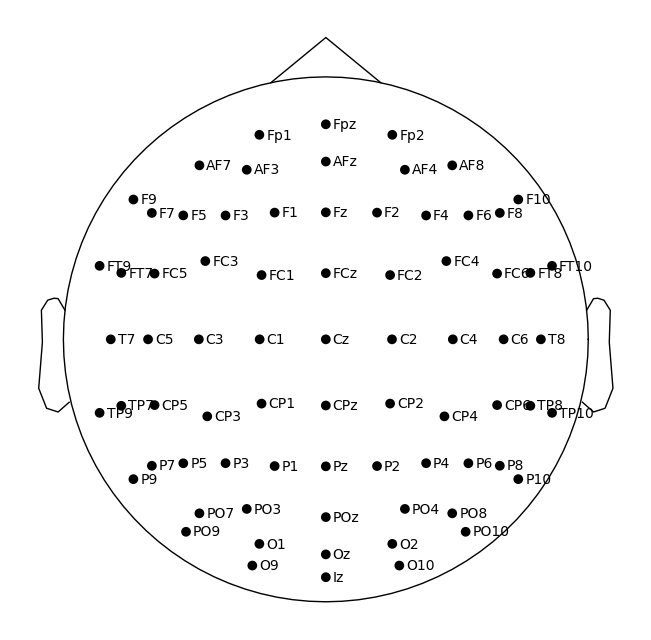

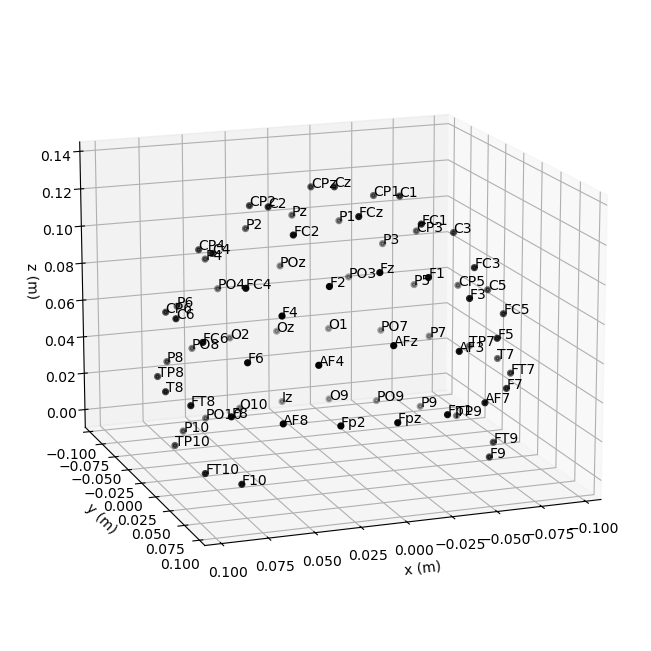

In [5]:
easycap_montage.plot()  # 2D
fig = easycap_montage.plot(kind="3d", show=False)  # 3D
fig = fig.gca().view_init(azim=70, elev=15)  # set view angle for tutorial

Once loaded, a montage can be applied to data with the
`~mne.io.Raw.set_montage` method, for example
`raw.set_montage() <mne.io.Raw.set_montage>`,
`epochs.set_montage() <mne.Epochs.set_montage>`, or
`evoked.set_montage() <mne.Evoked.set_montage>`. This will only work with
data whose EEG channel names correspond to those in the montage.
(Therefore, we're loading some EEG data below, and not the usual MNE "sample"
dataset.)

You can then visualize the sensor locations via the
:meth:`~mne.io.Raw.plot_sensors` method.

It is also possible to skip the manual montage loading step by passing the
montage name directly to the :meth:`~mne.io.Raw.set_montage` method.



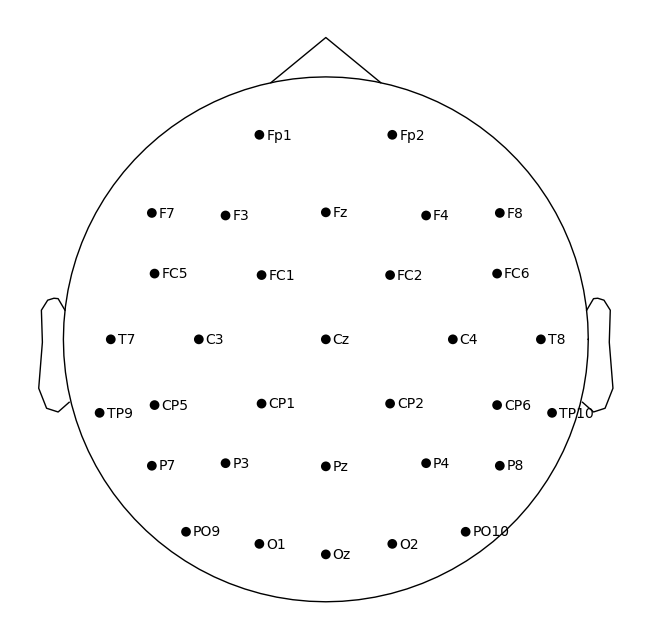

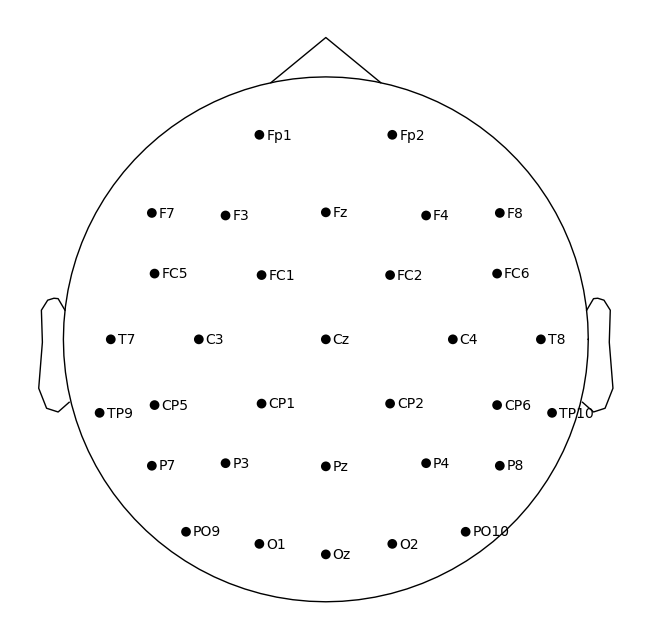

In [6]:
ssvep_folder = mne.datasets.ssvep.data_path()
ssvep_data_raw_path = (
    ssvep_folder / "sub-02" / "ses-01" / "eeg" / "sub-02_ses-01_task-ssvep_eeg.vhdr"
)
ssvep_raw = mne.io.read_raw_brainvision(ssvep_data_raw_path, verbose=False)

# Use the preloaded montage
ssvep_raw.set_montage(easycap_montage)
fig = ssvep_raw.plot_sensors(show_names=True)

# Apply a template montage directly, without preloading
ssvep_raw.set_montage("easycap-M1")
fig = ssvep_raw.plot_sensors(show_names=True)

<div class="alert alert-info"><h4>Note</h4><p>You may have noticed that the figures created via
   :meth:`~mne.io.Raw.plot_sensors` contain fewer sensors than the result of
   `easycap_montage.plot() <mne.channels.DigMontage.plot>`. This is because
   the montage contains *all channels defined for that EEG system*; but not
   all recordings will necessarily use all possible channels. Thus when
   applying a montage to an actual EEG dataset, information about sensors
   that are not actually present in the data is removed.</p></div>

## Plotting 2D sensor locations like EEGLAB

.. admonition:: The ``sphere`` keyword is available in many places!
    :class: sidebar hint

    All MNE plotting functions for EEG topographies and sensor locations
    support the ``sphere`` keyword argument, and therefore allow for
    adjustment of the way the sensors are projected onto the head circle.

In MNE-Python, by default the head center is calculated using
:term:`fiducial points <fiducial>`. This means that
the head circle represents the head circumference **at the nasion and ear
level,** and not where it is commonly measured in the 10–20 EEG system
(i.e., above the nasion at T4/T8, T3/T7, Oz, and Fpz).

If you prefer to draw the head circle using 10–20 conventions (which are also
used by EEGLAB), you can pass ``sphere='eeglab'``:



Approximating Fpz location by mirroring Oz along the X and Y axes.


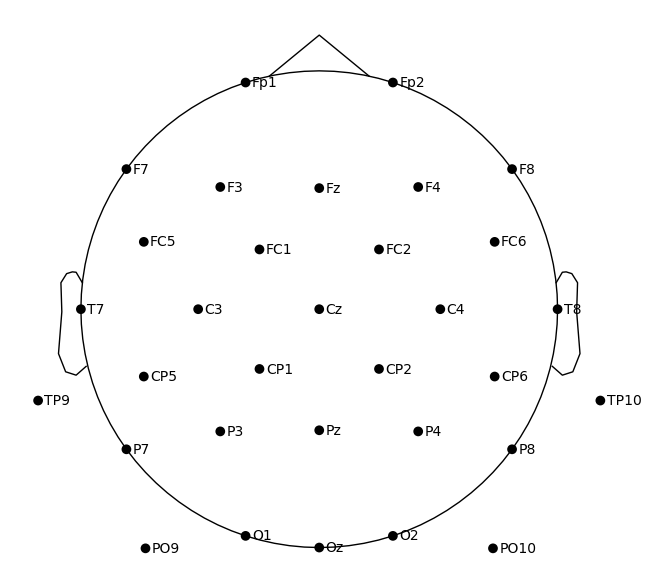

In [7]:
fig = ssvep_raw.plot_sensors(show_names=True, sphere="eeglab")

Because the data we're using here doesn't contain an Fpz channel, its
putative location was approximated automatically.


## Manually controlling 2D channel projection

Channel positions in 2D space are obtained by projecting their actual 3D
positions onto a sphere, then projecting the sphere onto a plane.
By default, a sphere with origin at ``(0, 0, 0)`` (x, y, z coordinates) and
radius of ``0.095`` meters (9.5 cm) is used. You can use a different sphere
radius by passing a single value as the  ``sphere`` argument in any function
that plots channels in 2D (like `~mne.channels.DigMontage.plot` that we use
here, but also for example `mne.viz.plot_topomap`):



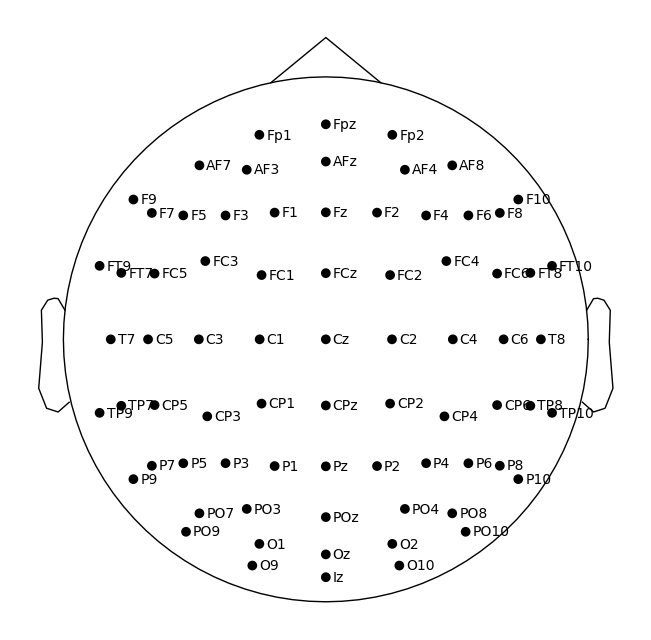

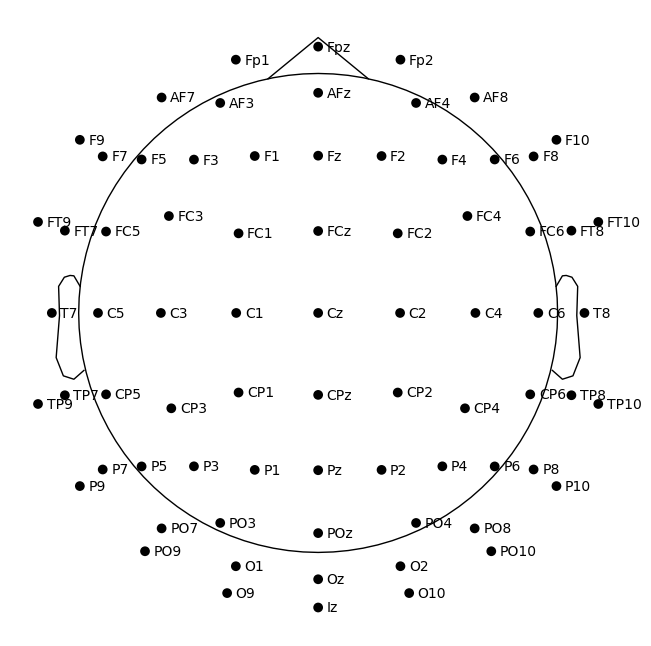

In [8]:
fig1 = easycap_montage.plot()  # default radius of 0.095
fig2 = easycap_montage.plot(sphere=0.07)

To change not only the radius, but also the sphere origin, pass a
``(x, y, z, radius)`` tuple as the ``sphere`` argument:



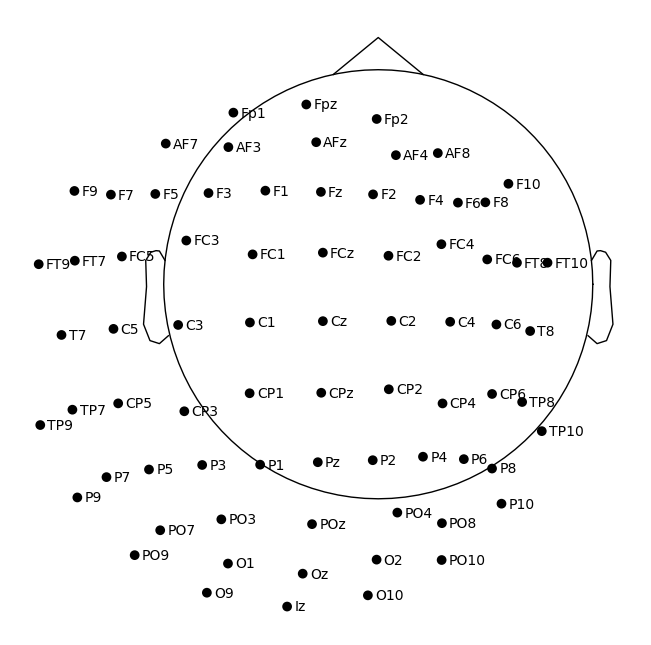

In [9]:
fig = easycap_montage.plot(sphere=(0.03, 0.02, 0.01, 0.075))


## Reading sensor digitization files

In the sample data, the sensor positions are already available in the
``info`` attribute of the `~mne.io.Raw` object (see the documentation of the
reading functions and :meth:`~mne.io.Raw.set_montage` for details on how that
works). Therefore, we can plot sensor locations directly from the
`~mne.io.Raw` object using :meth:`~mne.io.Raw.plot_sensors`, which provides
similar functionality to `montage.plot() <mne.channels.DigMontage.plot>`. In
addition, :meth:`~mne.io.Raw.plot_sensors` supports channel selection by
type, color-coding channels in various ways (by default, channels listed in
``raw.info['bads']`` will be plotted in red), and drawing in an existing
Matplotlib ``Axes`` object (so the channel positions can easily be added as a
subplot in a multi-panel figure):



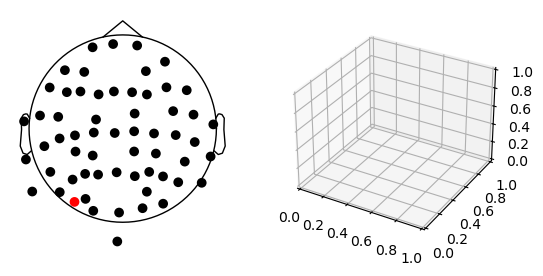

In [10]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_path = sample_data_folder / "MEG" / "sample" / "sample_audvis_raw.fif"
sample_raw = mne.io.read_raw_fif(sample_data_raw_path, preload=False, verbose=False)

fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection="3d")
sample_raw.plot_sensors(ch_type="eeg", axes=ax2d)
sample_raw.plot_sensors(ch_type="eeg", axes=ax3d, kind="3d")
ax3d.view_init(azim=70, elev=15)

The previous 2D topomap reveals irregularities in the EEG sensor positions in
the `sample dataset <sample-dataset>` — this is because the sensor
positions in that dataset are digitizations of actual sensor positions on the
head rather than idealized sensor positions based on a spherical head model.
Depending on the digitization device (e.g., a Polhemus Fastrak digitizer),
you need to use different montage reading functions (see `dig-formats`).
The resulting `montage <mne.channels.DigMontage>` can then be added to
`~mne.io.Raw` objects by passing it as an argument to the
:meth:`~mne.io.Raw.set_montage` method (just as we did before with the name
of the predefined ``'standard_1020'`` montage). Once loaded, locations can be
plotted with the :meth:`~mne.channels.DigMontage.plot` method and saved with
the :meth:`~mne.channels.DigMontage.save` method of the
`montage <mne.channels.DigMontage>` object.

<div class="alert alert-info"><h4>Note</h4><p>When setting a montage with :meth:`~mne.io.Raw.set_montage`, the
    measurement info is updated in two places (both ``chs`` and ``dig``
    entries are updated) – see `tut-info-class` for more details. Note
    that ``dig`` may contain HPI, fiducial, or head shape points in addition
    to electrode locations.</p></div>


## Visualizing sensors in 3D surface renderings

It is also possible to render an image of an MEG sensor helmet using 3D
surface rendering instead of matplotlib. This works by calling
:func:`mne.viz.plot_alignment`:



In [11]:
fig = mne.viz.plot_alignment(
    sample_raw.info,
    dig=False,
    eeg=False,
    surfaces=[],
    meg=["helmet", "sensors"],
    coord_frame="meg",
)
mne.viz.set_3d_view(fig, azimuth=50, elevation=90, distance=0.5)

Using pyvistaqt 3d backend.


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Getting helmet for system 306m
Channel types::	grad: 203, mag: 102


Note that :func:`~mne.viz.plot_alignment` requires an `~mne.Info` object, and
can also render MRI surfaces of the scalp, skull, and brain (by passing a
dict with keys like ``'head'``, ``'outer_skull'`` or ``'brain'`` to the
``surfaces`` parameter). This makes the function useful for
`assessing coordinate frame transformations <tut-source-alignment>`.
For examples of various uses of :func:`~mne.viz.plot_alignment`, see
`plot_montage`, `ex-eeg-on-scalp`, and `ex-plot-meg-sensors`.


## Working with layout files

Similar to montages, many layout files are included with MNE-Python. They are
stored in the :file:`mne/channels/data/layouts` folder:



In [12]:
layout_dir = Path(mne.__file__).parent / "channels" / "data" / "layouts"
layouts = sorted(path.name for path in layout_dir.iterdir())
print("\nBUILT-IN LAYOUTS\n================")
print("\n".join(layouts))


BUILT-IN LAYOUTS
CTF-275.lout
CTF151.lay
CTF275.lay
EEG1005.lay
EGI256.lout
GeodesicHeadWeb-130.lout
GeodesicHeadWeb-280.lout
KIT-125.lout
KIT-157.lout
KIT-160.lay
KIT-AD.lout
KIT-AS-2008.lout
KIT-UMD-3.lout
Neuromag_122.lout
Vectorview-all.lout
Vectorview-grad.lout
Vectorview-grad_norm.lout
Vectorview-mag.lout
biosemi.lay
magnesWH3600.lout


To load a layout file, use the `mne.channels.read_layout` function.
You can then visualize the layout using its
`~mne.channels.Layout.plot` method:



In [13]:
biosemi_layout = mne.channels.read_layout("biosemi")

Similar to the ``picks`` argument for selecting channels from `~mne.io.Raw`
objects, the :meth:`~mne.channels.Layout.plot` method of
`~mne.channels.Layout` objects also has a ``picks`` argument. However,
because layouts only contain information about sensor name and location (not
sensor type), the :meth:`~mne.channels.Layout.plot` method only supports
picking channels by index (not by name or by type). In the following example,
we find the desired indices using :func:`numpy.where`; selection by name or
type is possible with :func:`mne.pick_channels` or :func:`mne.pick_types`.



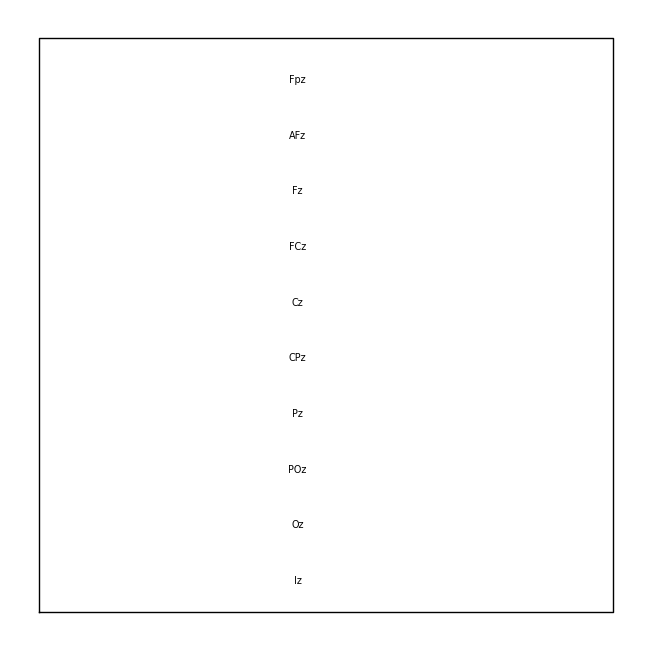

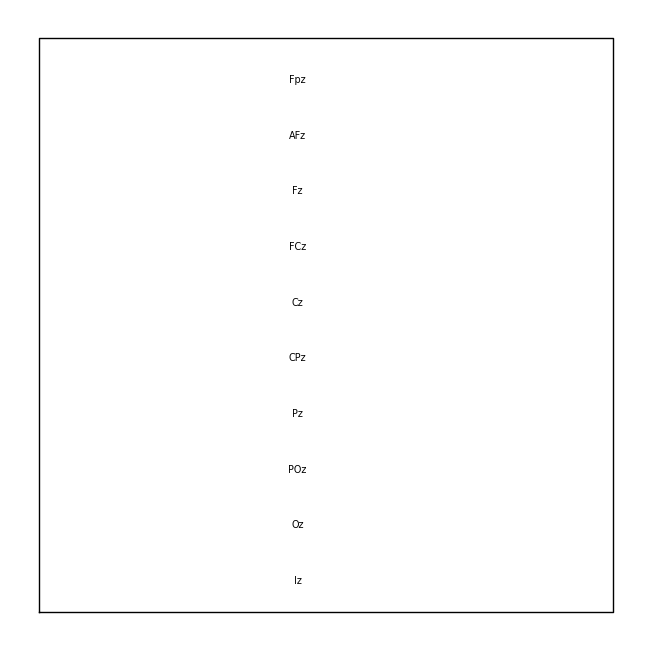

In [14]:
midline = np.where([name.endswith("z") for name in biosemi_layout.names])[0]
biosemi_layout.plot(picks=midline)

If you have a `~mne.io.Raw` object that contains sensor positions, you can
create a `~mne.channels.Layout` object with either
:func:`mne.channels.make_eeg_layout` or :func:`mne.channels.find_layout`.



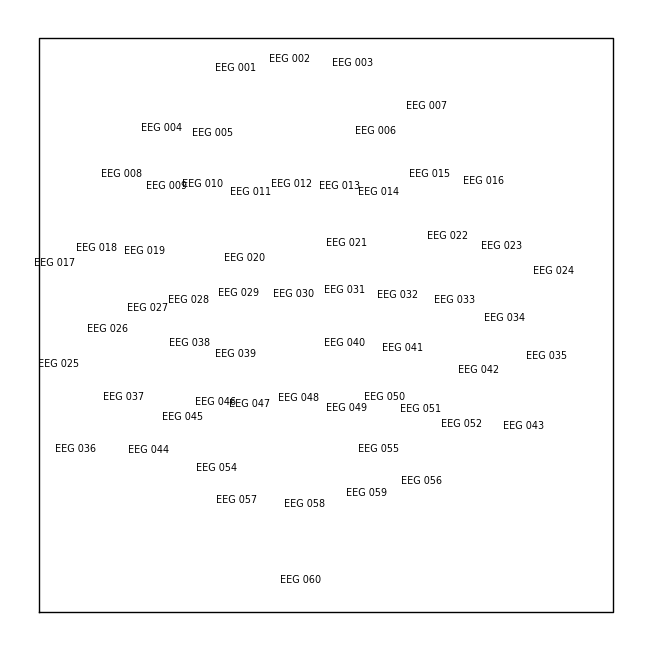

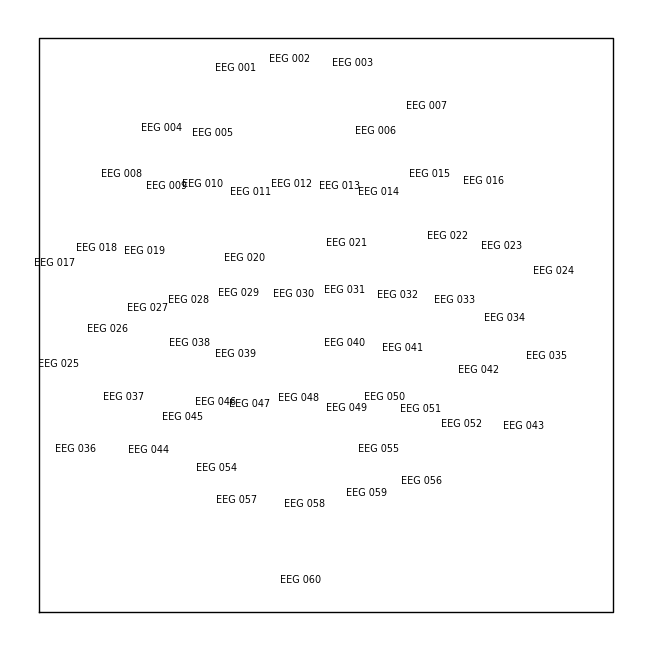

In [15]:
layout_from_raw = mne.channels.make_eeg_layout(sample_raw.info)
# same result as mne.channels.find_layout(raw.info, ch_type='eeg')
layout_from_raw.plot()

<div class="alert alert-info"><h4>Note</h4><p>There is no corresponding ``make_meg_layout()`` function because sensor
    locations are fixed in an MEG system (unlike in EEG, where sensor caps
    deform to fit snugly on a specific head). Therefore, MEG layouts are
    consistent (constant) for a given system and you can simply load them
    with :func:`mne.channels.read_layout` or use
    :func:`mne.channels.find_layout` with
    the ``ch_type`` parameter (as previously demonstrated for EEG).</p></div>

All `~mne.channels.Layout` objects have a `~mne.channels.Layout.save` method
that writes layouts to disk as either :file:`.lout` or :file:`.lay` formats
(inferred from the file extension contained in the ``fname`` argument). The
choice between :file:`.lout` and :file:`.lay` format only matters if you need
to load the layout file in some other application (MNE-Python can read both
formats).


.. LINKS


